## Introduction

This project aims to build a classification model that predicts wine quality based on its physicochemical properties using machine learning techniques. The dataset used is the Wine Quality dataset from the UCI Machine Learning Repository, which contains measurements like acidity, sugar content, sulfur dioxide levels, pH, and alcohol percentage for various red wine samples.

Originally, the quality attribute is a numeric score ranging from 0 to 10, based on human sensory evaluations. However, since the scores are subjective, imbalanced, and ordered, we transform this into a binary classification task to simplify the modeling process.

Using pandas.cut(), we divide the quality scores into two categories:
- "bad": quality scores from 2 up to and including 6.5
- "good": quality scores above 6.5 up to 8

This transformation allows us to frame the problem as a binary classification task, where we train machine learning models to classify whether a wine is of good quality or not.

The project applies several classification algorithms such as Decision Tree, Naive Bayes, and K-Nearest Neighbors (KNN). The performance of these models is evaluated using metrics like accuracy, precision, recall, F1-score, and ROC-AUC, allowing us to understand which physicochemical factors best predict wine quality and which model generalizes well.

# Importing required packages.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
%matplotlib inline

# Loading the dataset

In [2]:
wine = pd.read_csv('winequality-red.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Information on the dataset

In [3]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


### Checking for duplicates

In [4]:
print("Duplicates:", wine.duplicated().sum())

Duplicates: 240


Since duplicates exist, we will remove them

In [5]:
wine = wine.drop_duplicates()

# Recheck for duplicates
print("Duplicates:", wine.duplicated().sum())

Duplicates: 0


### Checking for outliers

To ensure the quality of our dataset, we identify and remove outliers using the Interquartile Range (IQR) method. Outliers can skew the model's understanding of the data, especially for algorithms sensitive to distance or variance.

We calculate:

- Q1 (25th percentile)
- Q3 (75th percentile)
- IQR = Q3 - Q1

Then we remove any rows where a feature value is below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.

Visualization Before Outliers Removal

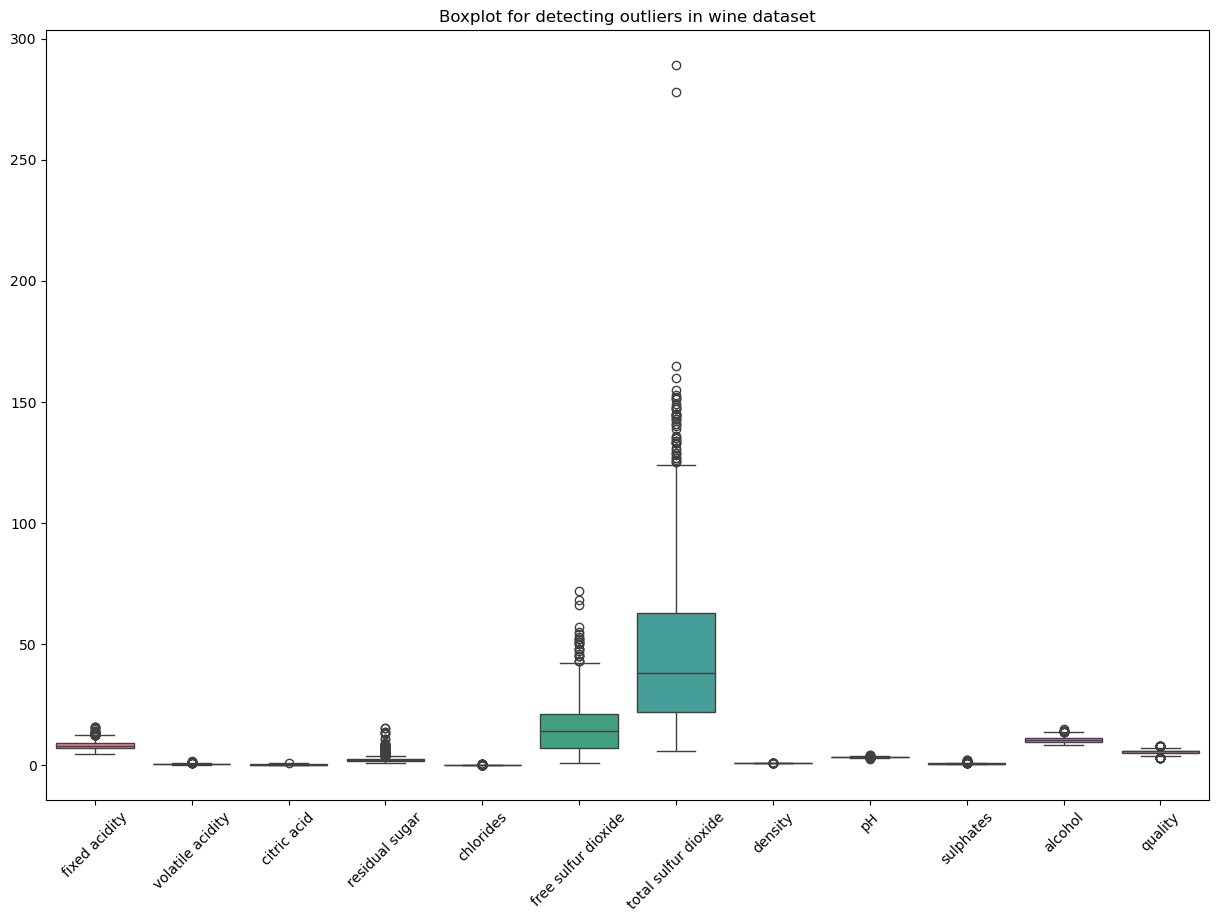

In [6]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=wine)
plt.title("Boxplot for detecting outliers in wine dataset")
plt.xticks(rotation=45)
plt.show()

### Outlier Removal Justification (Using 1.15 * IQR)

Outliers in the dataset can negatively affect model performance, especially for distance-based models like K-Nearest Neighbors (KNN). The Interquartile Range (IQR) method is a common approach for detecting and removing outliers.

By default, the standard IQR rule uses a multiplier of **1.5**:  
**Outlier Threshold = [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]**

In this project, we use a slightly stricter threshold of **1.15**:  
**Threshold = [Q1 - 1.15 * IQR, Q3 + 1.15 * IQR]**

This slightly tighter bound removes more borderline outliers than the standard method, which is appropriate because:

- The boxplots show many mild outliers in features like **free sulfur dioxide**, **residual sugar**, and **alcohol**.
- Some of these values may represent noise or data-entry errors.
- Removing them reduces skew and improves training signal quality.
- It especially helps models sensitive to feature scales and extremes, such as **KNN**.

Thus, using `1.15 * IQR` strikes a balance between cleaning the data and retaining useful samples.


In [7]:
# Checking for outliers using the IQR method
Q1 = wine.quantile(0.25)
Q3 = wine.quantile(0.75)
IQR = Q3 - Q1

# Removing rows with any feature having an outlier
wine = wine[~((wine < (Q1 - 1.15 * IQR)) | (wine > (Q3 + 1.15 * IQR))).any(axis=1)]

Visualization After Outliers Removal

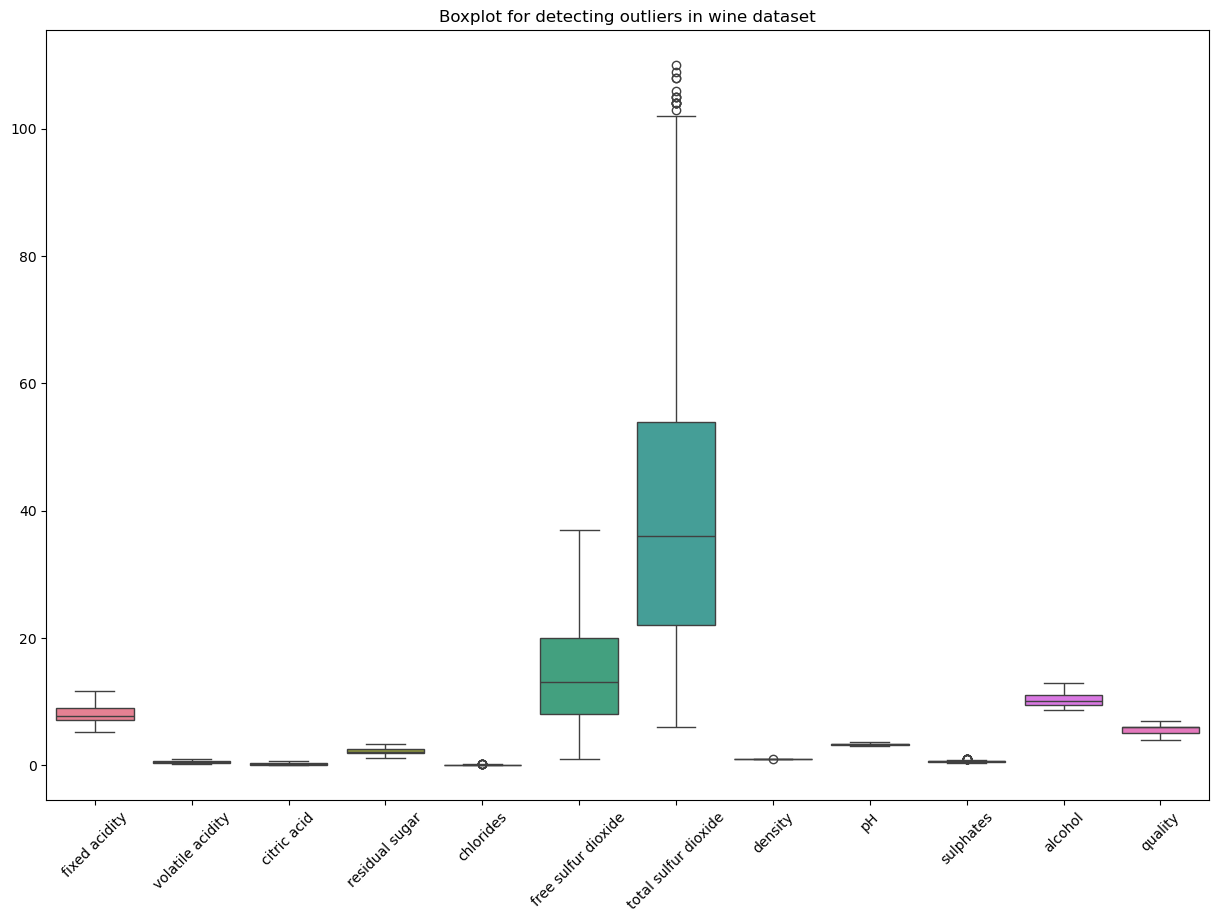

In [8]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=wine)
plt.title("Boxplot for detecting outliers in wine dataset")
plt.xticks(rotation=45)
plt.show()

# Column distribution

To understand the relationship between physicochemical properties and wine quality, we use bar plots to visualize how different features vary across quality scores.

These visualizations help us identify which features might be informative for predicting wine quality for example, does higher citric acid or fixed acidity correlate with better wine?

<Axes: xlabel='quality', ylabel='fixed acidity'>

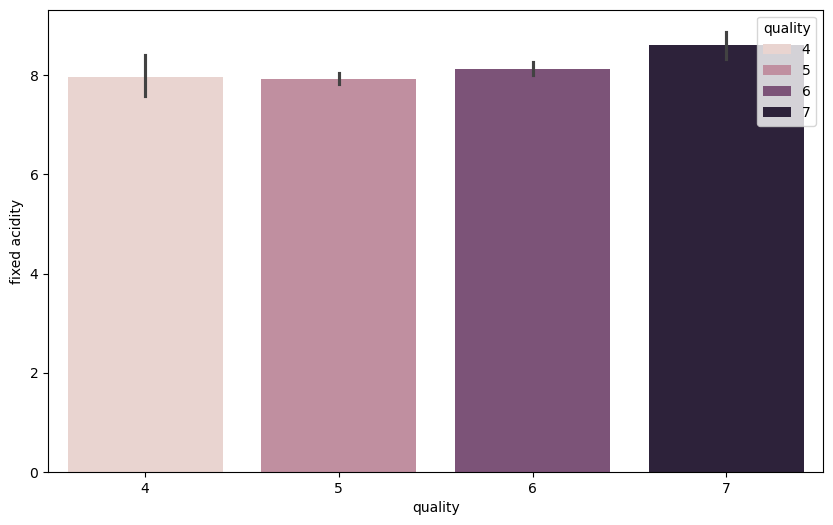

In [9]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', y='fixed acidity', x='quality', data=wine)

<Axes: xlabel='quality', ylabel='citric acid'>

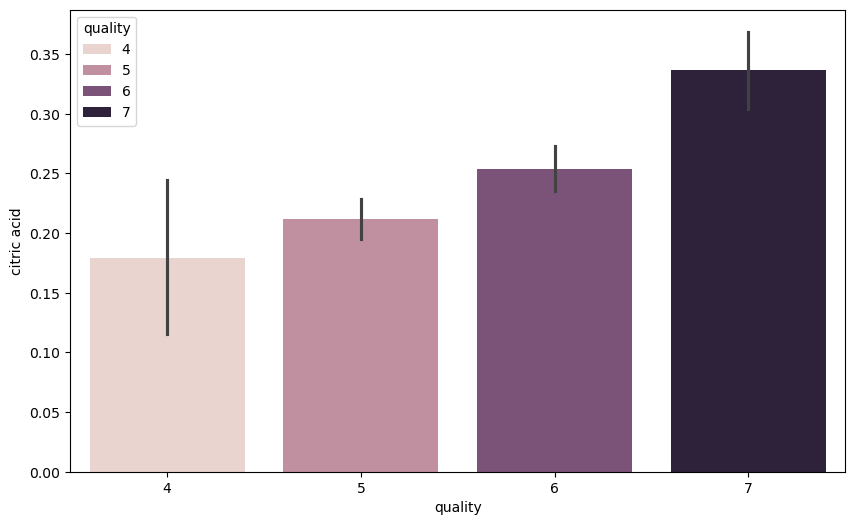

In [10]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', x = 'quality', y = 'citric acid', data = wine)

<Axes: xlabel='quality', ylabel='residual sugar'>

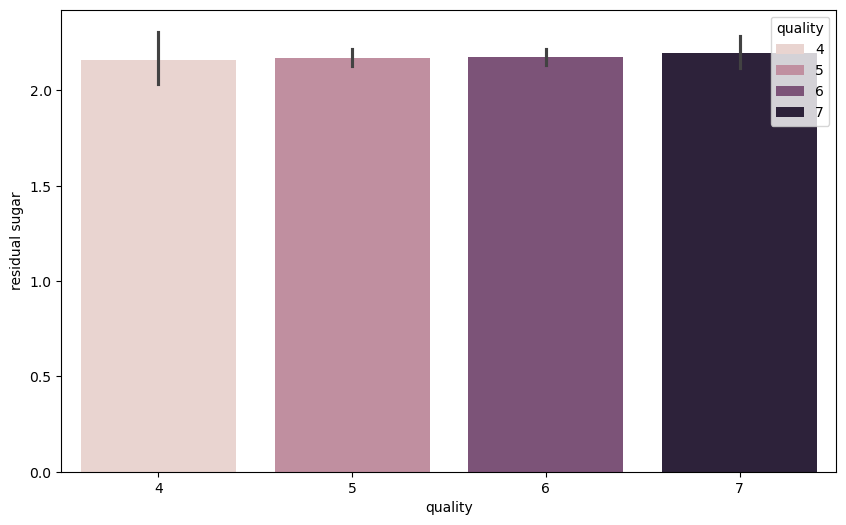

In [11]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', x = 'quality', y = 'residual sugar', data = wine)

<Axes: xlabel='quality', ylabel='chlorides'>

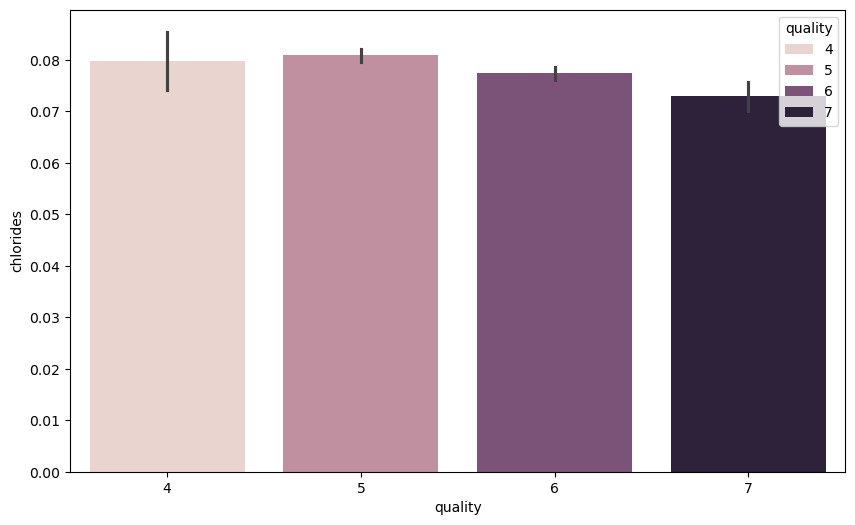

In [12]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', x = 'quality', y = 'chlorides', data = wine)

<Axes: xlabel='quality', ylabel='free sulfur dioxide'>

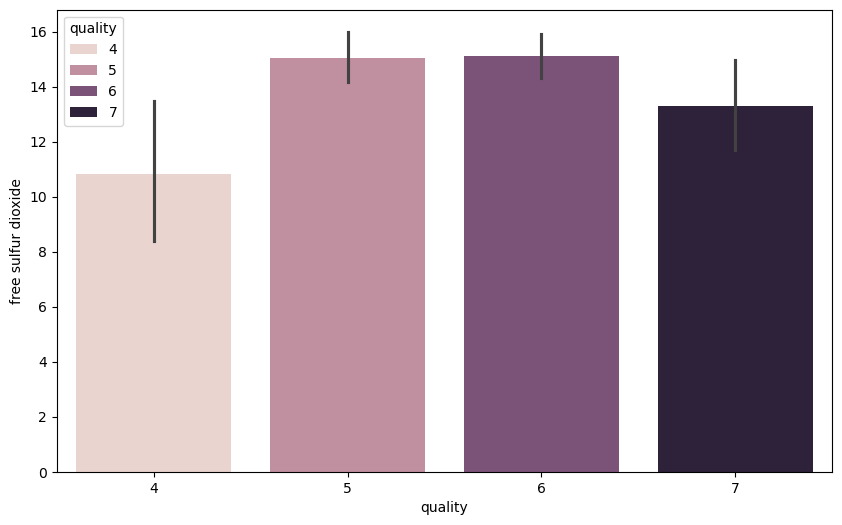

In [13]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', x = 'quality', y = 'free sulfur dioxide', data = wine)

<Axes: xlabel='quality', ylabel='total sulfur dioxide'>

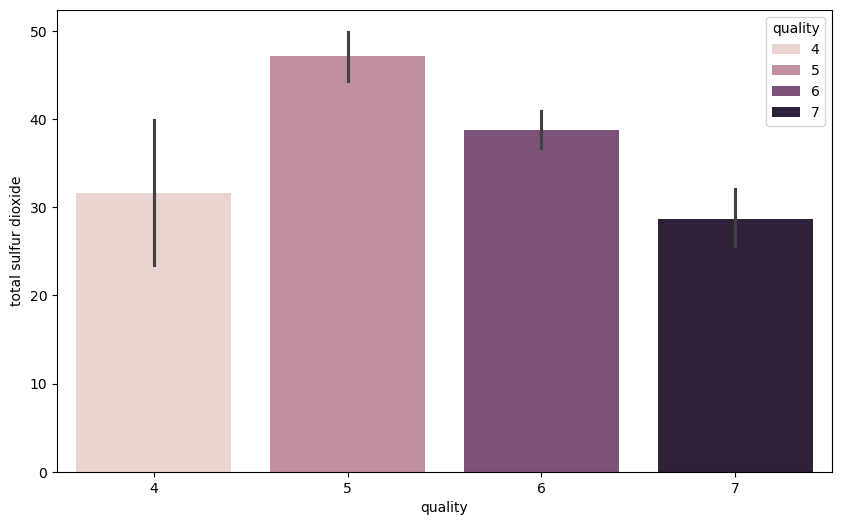

In [14]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', x = 'quality', y = 'total sulfur dioxide', data = wine)

<Axes: xlabel='quality', ylabel='sulphates'>

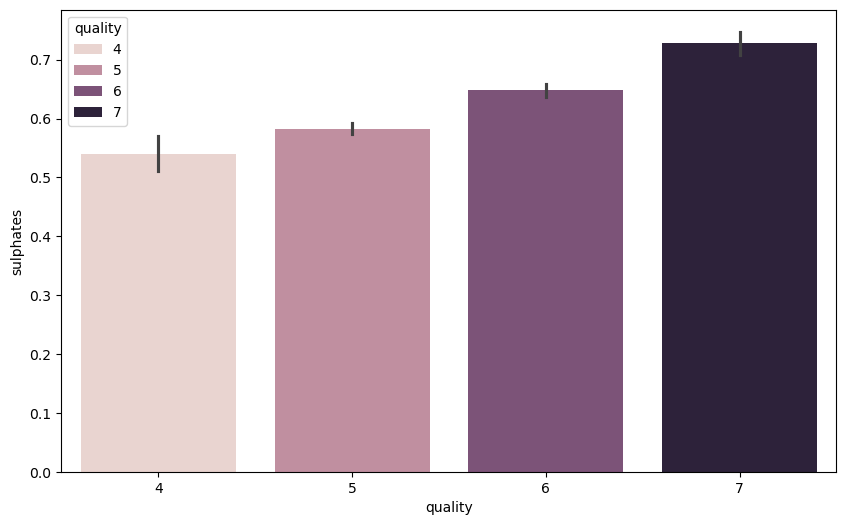

In [15]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', x = 'quality', y = 'sulphates', data = wine)

<Axes: xlabel='quality', ylabel='alcohol'>

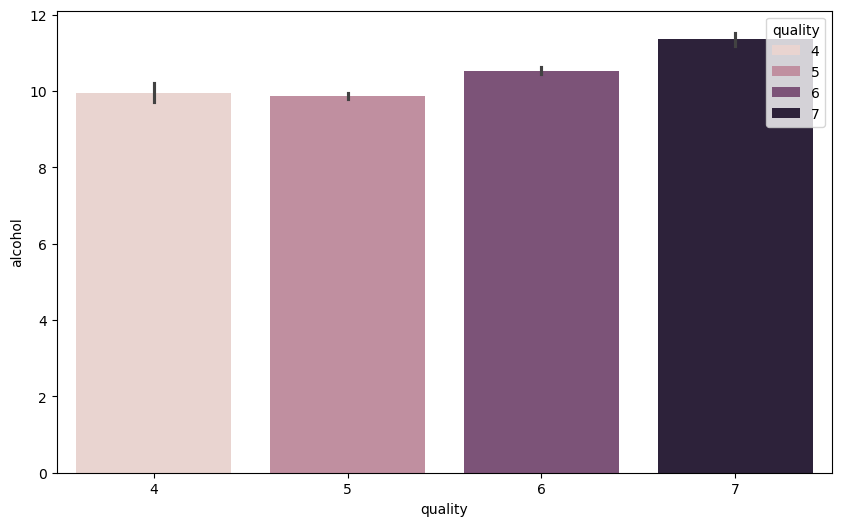

In [16]:
fig = plt.figure(figsize = (10,6))
sns.barplot(hue='quality', x = 'quality', y = 'alcohol', data = wine)

# Correlation Heatmap

This heatmap helps us see which features are strongly related to each other or to the target variable (`quality`).

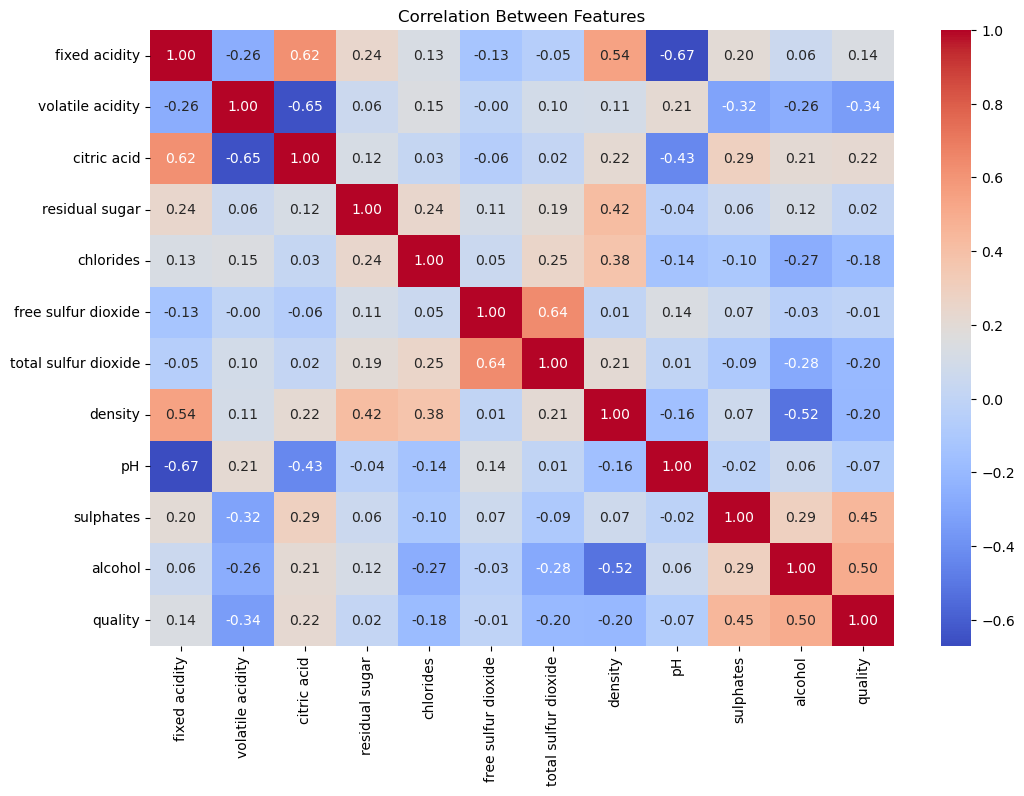

In [17]:
# Plotting the correlation heatmap
plt.figure(figsize=(12,8))  # Set figure size
sns.heatmap(wine.corr(), annot=True, fmt=".2f", cmap='coolwarm')  # Create heatmap
plt.title("Correlation Between Features")  # Add title
plt.show()  # Display the plot

# Preprocessing Data

We are transforming the `quality` column from a multi-class numerical scale into a **binary classification** problem. 

The original `quality` scores range from 2 to 8, but for simplicity and clarity, we categorize them into:
- `'bad'` for scores **≤ 6.5**
- `'good'` for scores **> 6.5**

This binning helps us build models that predict whether a wine is good or bad, rather than predicting an exact score.

Then, we **encode** these categorical labels (`'bad'`, `'good'`) into numerical values (`0` and `1`) because machine learning models work with numbers.

Finally, we use a **count plot** to visualize the distribution of these two new categories to understand class balance.

<Axes: xlabel='quality', ylabel='count'>

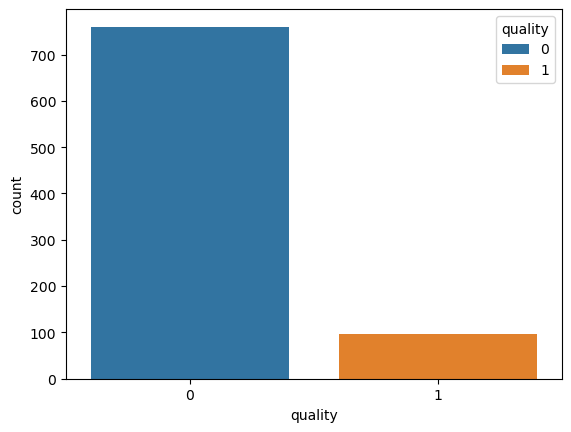

In [18]:
# Define the bin edges:
# quality scores from 2 to 6.5 will be labeled 'bad', and 6.5 to 8 as 'good'
bins = (2, 6.5, 8)

# Define the corresponding labels for the bins
group_names = ['bad', 'good']
wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = group_names)
label_quality = LabelEncoder()

#Bad becomes 0 and good becomes 1 
wine['quality'] = label_quality.fit_transform(wine['quality'])

sns.countplot(hue='quality', x='quality', data=wine)

Now that we've converted the wine quality into a binary label (bad or good), we're preparing the dataset for model training:

1. **Separate features and labels:**  
    We split the dataset into `X` (features) and `y` (target label, which is the encoded wine quality).  
    This allows the model to learn patterns from input features to predict the output class.

2. **Split the dataset:**  
    We divide it into training and testing sets using an 80/20 split.  
    The model will learn on the training set and be evaluated on the test set to measure performance on unseen data.

3. **Normalize the feature values:**  
    Using `StandardScaler`, we standardize the features so they all have the same scale (mean = 0, std = 1).  
    This step is **especially important for K-Nearest Neighbors (KNN)**, since it relies on distance calculations.  
    Even though Decision Tree and Naive Bayes don’t require feature scaling, we apply it here for consistency and to support models that do benefit from it.


In [19]:
# Keeping a copy of the original feature data
X_original = wine.drop('quality', axis=1).copy()

# Use the copied data as feature set
X = X_original  
y = wine['quality']  # Target variable

# Split data into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler for feature normalization
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)   # Fit + transform training data
X_test_scaled = sc.transform(X_test)        # Transform test data only

## Before vs After Normalization

Before training our machine learning models, we normalize the features using **Z-score normalization** to ensure all variables are on the same scale.

Why this matters:
- Some features like **alcohol** or **sulfur dioxide** have values that are much higher than others like **pH**, which can skew results in models like **KNN** that are sensitive to magnitude.
- **StandardScaler** transforms each feature to have a mean of 0 and a standard deviation of 1.

To visualize this transformation, we compare the original feature values to their normalized versions. This step helps confirm that normalization was applied correctly and highlights how much scaling affects the dataset.

In [20]:
# Create DataFrames for visualization
X_train_df_before = pd.DataFrame(X_train, columns=X.columns)
X_train_df_after = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_df_before = pd.DataFrame(X_test, columns=X.columns)
X_test_df_after = pd.DataFrame(X_test_scaled, columns=X.columns)

# Visual comparison
print("First 5 rows of training data (before normalization):")
display(X_train_df_before.head())

print("\nFirst 5 rows of training data (after normalization):")
display(X_train_df_after.head())

print("First 5 rows of test data (before normalization):")
display(X_test_df_before.head())

print("\nFirst 5 rows of test data (after normalization):")
display(X_test_df_after.head())

First 5 rows of training data (before normalization):


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5
356,11.5,0.41,0.52,3.0,0.080,29.0,55.0,1.0001,3.26,0.88,11.0
282,7.6,0.52,0.12,3.0,0.067,12.0,53.0,0.9971,3.36,0.57,9.1
648,8.7,0.48,0.30,2.8,0.066,10.0,28.0,0.9964,3.33,0.67,11.2
175,6.9,0.50,0.04,1.5,0.085,19.0,49.0,0.9958,3.35,0.78,9.5



First 5 rows of training data (after normalization):


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.214176,0.365036,-1.246184,-0.428093,-0.402603,-0.698629,-0.956171,0.166102,0.257008,-0.506450,-0.879274
1,2.651875,-0.685853,1.616253,1.936775,0.118163,1.786757,0.599295,2.428129,-0.574597,2.426322,0.701020
2,-0.369098,-0.005866,-0.673696,1.936775,-0.848974,-0.325821,0.515216,0.371741,0.257008,-0.506450,-1.300686
3,0.482971,-0.253134,0.356781,1.463801,-0.923369,-0.574360,-0.535775,-0.108083,0.007527,0.439605,0.911726
4,-0.911324,-0.129500,-1.131686,-1.610527,0.490139,0.544064,0.347057,-0.519360,0.173848,1.480266,-0.879274


First 5 rows of test data (before normalization):


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1356,6.1,0.340,0.25,1.8,0.084,4.0,28.0,0.99464,3.36,0.44,10.1
1160,10.6,0.360,0.57,2.3,0.087,6.0,20.0,0.99676,3.14,0.72,11.1
211,8.0,0.725,0.24,2.8,0.083,10.0,62.0,0.99685,3.35,0.56,10.0
392,9.5,0.370,0.52,2.0,0.082,6.0,26.0,0.99800,3.18,0.51,9.5
761,9.3,0.655,0.26,2.0,0.096,5.0,35.0,0.99738,3.25,0.42,9.6



First 5 rows of test data (after normalization):


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-1.531011,-1.118572,0.070537,-0.901066,0.415744,-1.319976,-0.535775,-1.314497,0.257008,-1.736323,-0.247157
1,1.954728,-0.994938,1.902496,0.281367,0.638930,-1.071437,-0.872092,0.138684,-1.572523,0.912633,0.806373
2,-0.059255,1.261383,0.013288,1.463801,0.341349,-0.574360,0.893572,0.200375,0.173848,-0.601056,-0.352510
3,1.102658,-0.933121,1.616253,-0.428093,0.266954,-1.071437,-0.619854,0.988657,-1.239881,-1.074084,-0.879274
4,0.947736,0.828664,0.127786,-0.428093,1.308486,-1.195707,-0.241498,0.563670,-0.657757,-1.925534,-0.773921


# Save features and labels

In [21]:
joblib.dump(X_train_scaled, 'X_train.pkl')
joblib.dump(X_test_scaled, 'X_test.pkl')
joblib.dump(y_train, 'y_train.pkl')
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']